### 1. Load up datasets for 3 months
This project will be using the first quarter 2024 data. 

In [1]:
# Load parquet file into dataframe
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import dask.dataframe as dd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor

Reuseable function to load required columns from parquet file

In [2]:
# Load file and ensure columns are in format to ease processing
def process_parquet(parquet_file_path, sample_frac=0.011):
    columns_needed = ['request_datetime', 'on_scene_datetime', 'PULocationID', 'DOLocationID', 'trip_time']

    # Read the specific columns
    df = pd.read_parquet(parquet_file_path, columns=columns_needed)
    
    # Sample a fraction of the dataframe to reduce memory usage and make processing faster
    sampled_df = df.sample(frac=sample_frac)
    
    # Convert datetime columns
    sampled_df['request_datetime'] = pd.to_datetime(sampled_df['request_datetime'])
    sampled_df['on_scene_datetime'] = pd.to_datetime(sampled_df['on_scene_datetime'])

    # Convert to second precision to save memory
    sampled_df['request_datetime'] = sampled_df['request_datetime'].values.astype('datetime64[s]')
    sampled_df['on_scene_datetime'] = sampled_df['on_scene_datetime'].values.astype('datetime64[s]')

    # Convert int64 to int32
    sampled_df['trip_time'] = sampled_df['trip_time'].astype('int32')
    
    # Calculate the wait_time in seconds
    sampled_df['wait_time'] = (sampled_df['on_scene_datetime'] - sampled_df['request_datetime']).dt.total_seconds()
    sampled_df['wait_time'] = sampled_df['wait_time'].astype('float32')
    
    return sampled_df

In [3]:
# Jan 2024
trip_jan = process_parquet('data/fhvhv_tripdata_2024-01.parquet')
trip_jan.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time
4438567,2024-01-08 17:16:35,NaT,168,167,779,NaN
5084595,2024-01-09 19:37:26,2024-01-09 19:42:27,222,77,927,301.0
1057322,2024-01-02 20:13:51,2024-01-02 20:14:20,163,243,1744,29.0
11705707,2024-01-19 21:46:03,2024-01-19 21:51:00,39,85,1590,297.0
13935146,2024-01-23 06:18:53,NaT,9,179,1368,NaN


In [4]:
# Feb 2024
trip_feb = process_parquet('data/fhvhv_tripdata_2024-02.parquet') 
trip_feb.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time
18116263,2024-02-28 08:06:10,2024-02-28 08:14:16,232,132,2700,486.0
14968831,2024-02-23 15:41:32,2024-02-23 15:43:52,69,254,1836,140.0
5169098,2024-02-08 22:43:40,NaT,164,211,743,NaN
13393247,2024-02-21 06:55:07,2024-02-21 06:56:22,116,74,742,75.0
277161,2024-02-01 13:20:14,2024-02-01 13:20:28,162,237,1118,14.0


In [5]:
# Mar 2024
trip_mar = process_parquet('data/fhvhv_tripdata_2024-03.parquet') 
trip_mar.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time
20500770,2024-03-30 21:48:12,2024-03-30 21:54:00,92,83,824,348.0
14023694,2024-03-21 15:09:42,2024-03-21 15:10:57,68,246,456,75.0
15583358,2024-03-23 15:26:47,2024-03-23 15:46:01,186,161,2070,1154.0
923015,2024-03-02 07:44:03,NaT,249,151,1108,NaN
5103918,2024-03-08 09:31:48,2024-03-08 09:33:38,61,188,916,110.0


In [6]:
# Merge the three dataframes, ensure the merge is optimised
trips = pd.concat([trip_jan, trip_feb, trip_mar], ignore_index=True)

trips.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time
0,2024-01-08 17:16:35,NaT,168,167,779,NaN
1,2024-01-09 19:37:26,2024-01-09 19:42:27,222,77,927,301.0
2,2024-01-02 20:13:51,2024-01-02 20:14:20,163,243,1744,29.0
3,2024-01-19 21:46:03,2024-01-19 21:51:00,39,85,1590,297.0
4,2024-01-23 06:18:53,NaT,9,179,1368,NaN


In [7]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663343 entries, 0 to 663342
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype        
---  ------             --------------   -----        
 0   request_datetime   663343 non-null  datetime64[s]
 1   on_scene_datetime  489066 non-null  datetime64[s]
 2   PULocationID       663343 non-null  int32        
 3   DOLocationID       663343 non-null  int32        
 4   trip_time          663343 non-null  int32        
 5   wait_time          489066 non-null  float32      
dtypes: datetime64[s](2), float32(1), int32(3)
memory usage: 20.2 MB


### 2. Data Exploration

In [8]:
# Shape of dataframe
trips.shape

(663343, 6)

In [9]:
trips.describe()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time
count,663343,489066,663343.000000,663343.000000,663343.000000,489066.000000
mean,2024-02-16 10:39:48,2024-02-16 13:01:15,138.641869,141.888432,1148.538721,191.308350
min,2023-12-31 23:53:51,2023-12-31 23:52:45,3.000000,1.000000,1.000000,-6459.000000
25%,2024-01-24 23:49:56,2024-01-25 08:43:11,75.000000,75.000000,585.000000,96.000000
50%,2024-02-16 18:30:16,2024-02-16 17:39:51,140.000000,141.000000,940.000000,163.000000
75%,2024-03-09 17:18:40,2024-03-09 19:31:33,210.000000,216.000000,1480.000000,259.000000
max,2024-03-31 23:58:02,2024-03-31 23:58:59,265.000000,265.000000,52060.000000,6710.000000
std,NaN,NaN,74.939105,77.768133,807.062627,191.483734


In [10]:
# Check for nulls
trips.isnull().sum()

request_datetime          0
on_scene_datetime    174277
PULocationID              0
DOLocationID              0
trip_time                 0
wait_time            174277
dtype: int64

In [11]:
# Drop nulls there is more than enough data
trips = trips.dropna()
trips.shape

(489066, 6)

<Axes: xlabel='wait_time'>

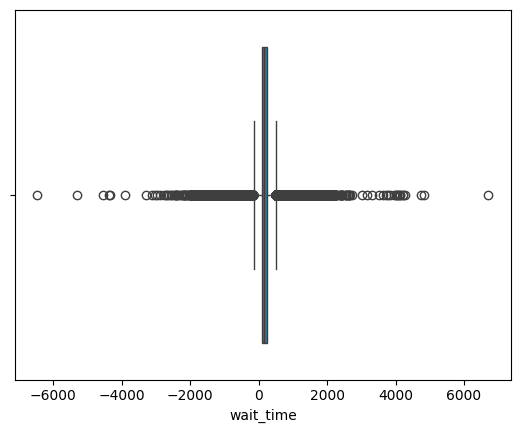

In [12]:
# Wait time seems to have some negative values from the min. Using boxplot to investigate more
sns.boxplot(x=trips['wait_time'])

In [13]:
# Get the count of negative wait times.
trips[trips['wait_time'] < 0]['wait_time'].count()

4541

In [14]:
# Drop negative wait times
trips = trips[trips['wait_time'] >= 0]

trips.shape

(484525, 6)

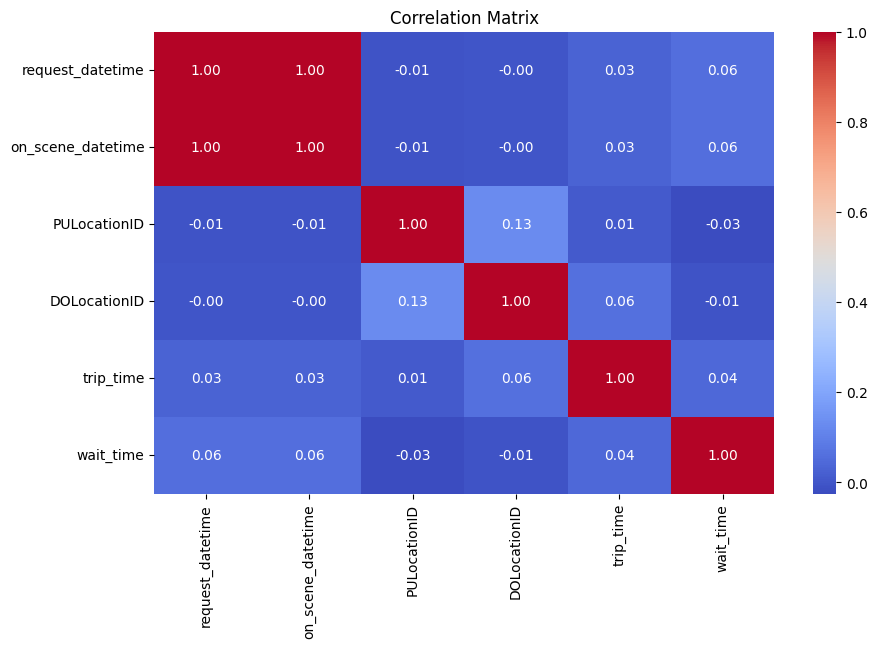

In [15]:
# understand the relationship between variables
plt.figure(figsize=(10, 6))
sns.heatmap(trips.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


### 3. Add external data and features
#### 3.1. Add Holidays in NYC data

In [16]:
# Holidays
from datetime import date
import holidays

ny_holidays = holidays.country_holidays('US', subdiv='NY', years=2024)

# Load ny_holidays into dataframe, date and holiday name
ny_holidays_df = pd.DataFrame.from_dict(ny_holidays, orient='index')
ny_holidays_df

,0
2024-01-01,New Year's Day
2024-05-27,Memorial Day
2024-06-19,Juneteenth National Independence Day
2024-07-04,Independence Day
2024-09-02,Labor Day
2024-11-11,Veterans Day
2024-11-28,Thanksgiving
2024-12-25,Christmas Day
2024-01-15,Martin Luther King Jr. Day
2024-02-19,Washington's Birthday


In [17]:
# Reset index and rename columns
ny_holidays_df.reset_index(inplace=True)
ny_holidays_df.columns = ['date', 'holiday_name']
ny_holidays_df

,date,holiday_name
0,2024-01-01,New Year's Day
1,2024-05-27,Memorial Day
2,2024-06-19,Juneteenth National Independence Day
3,2024-07-04,Independence Day
4,2024-09-02,Labor Day
5,2024-11-11,Veterans Day
6,2024-11-28,Thanksgiving
7,2024-12-25,Christmas Day
8,2024-01-15,Martin Luther King Jr. Day
9,2024-02-19,Washington's Birthday


In [18]:
# Convert holidays to datetime and create is_holiday flag in the trips dataframe
ny_holidays_df.index = pd.to_datetime(ny_holidays_df.index)
ny_holidays_df['date'].values.astype('datetime64[s]')
trips['is_holiday'] = trips['request_datetime'].dt.date.isin(ny_holidays_df['date']).astype(int)
trips.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday
1,2024-01-09 19:37:26,2024-01-09 19:42:27,222,77,927,301.0,0
2,2024-01-02 20:13:51,2024-01-02 20:14:20,163,243,1744,29.0,0
3,2024-01-19 21:46:03,2024-01-19 21:51:00,39,85,1590,297.0,0
5,2024-01-12 18:44:52,2024-01-12 18:46:22,80,7,1272,90.0,0
6,2024-01-21 16:52:10,2024-01-21 16:52:21,61,227,1446,11.0,0


In [19]:
# Keeping track of memory usage
trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 484525 entries, 1 to 663342
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype        
---  ------             --------------   -----        
 0   request_datetime   484525 non-null  datetime64[s]
 1   on_scene_datetime  484525 non-null  datetime64[s]
 2   PULocationID       484525 non-null  int32        
 3   DOLocationID       484525 non-null  int32        
 4   trip_time          484525 non-null  int32        
 5   wait_time          484525 non-null  float32      
 6   is_holiday         484525 non-null  int32        
dtypes: datetime64[s](2), float32(1), int32(4)
memory usage: 20.3 MB


#### 3.2. Add Time Based Features

In [20]:
# Hour of the day, day of the week, month, year
trips['hour'] = trips['request_datetime'].dt.hour
trips['week_day'] = trips['request_datetime'].dt.weekday
trips['month'] = trips['request_datetime'].dt.month

trips.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday,hour,week_day,month
1,2024-01-09 19:37:26,2024-01-09 19:42:27,222,77,927,301.0,0,19,1,1
2,2024-01-02 20:13:51,2024-01-02 20:14:20,163,243,1744,29.0,0,20,1,1
3,2024-01-19 21:46:03,2024-01-19 21:51:00,39,85,1590,297.0,0,21,4,1
5,2024-01-12 18:44:52,2024-01-12 18:46:22,80,7,1272,90.0,0,18,4,1
6,2024-01-21 16:52:10,2024-01-21 16:52:21,61,227,1446,11.0,0,16,6,1


In [21]:
# Define total trip time
trips['total_trip_time'] = trips['wait_time'] + trips['trip_time']
trips['total_trip_time'] = trips['wait_time'].astype('float32')
trips.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday,hour,week_day,month,total_trip_time
1,2024-01-09 19:37:26,2024-01-09 19:42:27,222,77,927,301.0,0,19,1,1,301.0
2,2024-01-02 20:13:51,2024-01-02 20:14:20,163,243,1744,29.0,0,20,1,1,29.0
3,2024-01-19 21:46:03,2024-01-19 21:51:00,39,85,1590,297.0,0,21,4,1,297.0
5,2024-01-12 18:44:52,2024-01-12 18:46:22,80,7,1272,90.0,0,18,4,1,90.0
6,2024-01-21 16:52:10,2024-01-21 16:52:21,61,227,1446,11.0,0,16,6,1,11.0


In [22]:
# Keeping track of memory usage
trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 484525 entries, 1 to 663342
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype        
---  ------             --------------   -----        
 0   request_datetime   484525 non-null  datetime64[s]
 1   on_scene_datetime  484525 non-null  datetime64[s]
 2   PULocationID       484525 non-null  int32        
 3   DOLocationID       484525 non-null  int32        
 4   trip_time          484525 non-null  int32        
 5   wait_time          484525 non-null  float32      
 6   is_holiday         484525 non-null  int32        
 7   hour               484525 non-null  int32        
 8   week_day           484525 non-null  int32        
 9   month              484525 non-null  int32        
 10  total_trip_time    484525 non-null  float32      
dtypes: datetime64[s](2), float32(2), int32(7)
memory usage: 27.7 MB


#### 3.3. Group into Peak, off-peak and night time

In [23]:
""" 
    Group request datetime into Peak, Off-Peak and Night
    Night: 10pm to 6am
    Off-Peak: Weekdays, 10am to 3pm and 7pm to 10pm. Weekends, 6am to 10pm
    Peak: Weekdays, 6am to 10am and 3pm to 7pm
"""

# Extract hour and day of week
hour = trips['hour']
week_day = trips['week_day']

# is holiday
is_holiday = trips['is_holiday'].astype(bool)

# Initialize the default group as Night (0)
trips['request_time_group'] = 0

# Define conditions for Peak (2) and OffPeak (1) times for weekday
weekday_mask = week_day < 5

peak_mask = (hour >= 6) & (hour < 10) | (hour >= 15) & (hour < 19)
off_peak_mask = (hour >= 10) & (hour < 15) | (hour >= 19) & (hour < 22)

# For weekend
weekend_mask = ~weekday_mask

# Apply conditions for weekdays
# Pandas is built to work efficiently with data in a vectorized way, meaning it can operate on entire columns (or Series) of data at once without needing an explicit loop
# .loc leverages the underlying numpy array to apply the mask to the dataframe without iterating over rows one by one
# note that all day during holidays are Off-Peak

# If day is not holiday, it will be Peak
trips.loc[weekday_mask & peak_mask & ~is_holiday, 'request_time_group'] = 2
# If day is holiday, it will be Off-Peak
trips.loc[weekday_mask & peak_mask & is_holiday, 'request_time_group'] = 1

trips.loc[weekday_mask & off_peak_mask, 'request_time_group'] = 1

# Apply conditions for weekends
trips.loc[weekend_mask & (hour >= 6) & (hour < 22), 'request_time_group'] = 1

trips.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday,hour,week_day,month,total_trip_time,request_time_group
1,2024-01-09 19:37:26,2024-01-09 19:42:27,222,77,927,301.0,0,19,1,1,301.0,1
2,2024-01-02 20:13:51,2024-01-02 20:14:20,163,243,1744,29.0,0,20,1,1,29.0,1
3,2024-01-19 21:46:03,2024-01-19 21:51:00,39,85,1590,297.0,0,21,4,1,297.0,1
5,2024-01-12 18:44:52,2024-01-12 18:46:22,80,7,1272,90.0,0,18,4,1,90.0,2
6,2024-01-21 16:52:10,2024-01-21 16:52:21,61,227,1446,11.0,0,16,6,1,11.0,1


In [24]:
# Keeping track of memory usage
trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 484525 entries, 1 to 663342
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype        
---  ------              --------------   -----        
 0   request_datetime    484525 non-null  datetime64[s]
 1   on_scene_datetime   484525 non-null  datetime64[s]
 2   PULocationID        484525 non-null  int32        
 3   DOLocationID        484525 non-null  int32        
 4   trip_time           484525 non-null  int32        
 5   wait_time           484525 non-null  float32      
 6   is_holiday          484525 non-null  int32        
 7   hour                484525 non-null  int32        
 8   week_day            484525 non-null  int32        
 9   month               484525 non-null  int32        
 10  total_trip_time     484525 non-null  float32      
 11  request_time_group  484525 non-null  int64        
dtypes: datetime64[s](2), float32(2), int32(7), int64(1)
memory usage: 31.4 MB


In [25]:
# Drop unneeded columns
trips.drop(['on_scene_datetime'], axis=1, inplace=True)

trips.head()

,request_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday,hour,week_day,month,total_trip_time,request_time_group
1,2024-01-09 19:37:26,222,77,927,301.0,0,19,1,1,301.0,1
2,2024-01-02 20:13:51,163,243,1744,29.0,0,20,1,1,29.0,1
3,2024-01-19 21:46:03,39,85,1590,297.0,0,21,4,1,297.0,1
5,2024-01-12 18:44:52,80,7,1272,90.0,0,18,4,1,90.0,2
6,2024-01-21 16:52:10,61,227,1446,11.0,0,16,6,1,11.0,1


In [26]:
# Keeping track of memory usage
trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 484525 entries, 1 to 663342
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype        
---  ------              --------------   -----        
 0   request_datetime    484525 non-null  datetime64[s]
 1   PULocationID        484525 non-null  int32        
 2   DOLocationID        484525 non-null  int32        
 3   trip_time           484525 non-null  int32        
 4   wait_time           484525 non-null  float32      
 5   is_holiday          484525 non-null  int32        
 6   hour                484525 non-null  int32        
 7   week_day            484525 non-null  int32        
 8   month               484525 non-null  int32        
 9   total_trip_time     484525 non-null  float32      
 10  request_time_group  484525 non-null  int64        
dtypes: datetime64[s](1), float32(2), int32(7), int64(1)
memory usage: 27.7 MB


#### 3.4. NYC weather

In [27]:
# Get Weather data
from datetime import datetime 
from meteostat import Point, Hourly, units  
# Set time period 
start = datetime(2024, 1, 1) 
end = datetime(2024, 3, 31)  
# Create Point for NY
location = Point(40.712775, -74.005973)  
# Get daily data 
weather_data = Hourly(location, start, end) 
weather_data = weather_data.convert(units.imperial) 
weather_data = weather_data.fetch()

weather_data.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2024-01-01 00:00:00,42.8,28.6,57.0,0.0,NaN,260.0,6.8,NaN,1017.0,NaN,3.0
2024-01-01 01:00:00,42.1,27.9,57.0,0.0,NaN,260.0,7.0,NaN,1016.4,NaN,3.0
2024-01-01 02:00:00,42.1,28.8,59.0,0.0,NaN,260.0,5.8,NaN,1016.4,NaN,3.0
2024-01-01 03:00:00,42.1,30.0,62.0,0.0,NaN,250.0,5.8,NaN,1016.4,NaN,3.0
2024-01-01 04:00:00,42.1,30.7,64.0,0.0,NaN,260.0,5.8,NaN,1016.5,NaN,3.0


In [28]:
# Reset index and convert time to datetime
weather_data.reset_index(inplace=True)
weather_data.rename(columns={'index': 'time'}, inplace=True)
weather_data['time'] = pd.to_datetime(weather_data['time'])

weather_data.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,2024-01-01 00:00:00,42.8,28.6,57.0,0.0,NaN,260.0,6.8,NaN,1017.0,NaN,3.0
1,2024-01-01 01:00:00,42.1,27.9,57.0,0.0,NaN,260.0,7.0,NaN,1016.4,NaN,3.0
2,2024-01-01 02:00:00,42.1,28.8,59.0,0.0,NaN,260.0,5.8,NaN,1016.4,NaN,3.0
3,2024-01-01 03:00:00,42.1,30.0,62.0,0.0,NaN,250.0,5.8,NaN,1016.4,NaN,3.0
4,2024-01-01 04:00:00,42.1,30.7,64.0,0.0,NaN,260.0,5.8,NaN,1016.5,NaN,3.0


In [29]:
# Create column to compare with weather time
trips['rounded_request_datetime'] = trips['request_datetime'].dt.round('H')

In [30]:
# Merge trips and weather dataframe on trips[rounded_request_datetime] and weather[time]
trips = trips.merge(weather_data, left_on='rounded_request_datetime', right_on='time', how='left')
trips.head()

,request_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday,hour,week_day,month,total_trip_time,...,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,2024-01-09 19:37:26,222,77,927,301.0,0,19,1,1,301.0,...,39.9,85.0,0.059,NaN,70.0,19.7,NaN,1015.1,NaN,9.0
1,2024-01-02 20:13:51,163,243,1744,29.0,0,20,1,1,29.0,...,24.8,43.0,0.000,NaN,260.0,4.7,NaN,1016.6,NaN,1.0
2,2024-01-19 21:46:03,39,85,1590,297.0,0,21,4,1,297.0,...,26.1,85.0,0.000,NaN,0.0,0.0,NaN,1008.6,NaN,3.0
3,2024-01-12 18:44:52,80,7,1272,90.0,0,18,4,1,90.0,...,30.2,52.0,0.000,NaN,100.0,9.2,NaN,1020.0,NaN,3.0
4,2024-01-21 16:52:10,61,227,1446,11.0,0,16,6,1,11.0,...,12.2,49.0,0.000,NaN,311.0,4.7,NaN,1027.6,NaN,1.0


In [31]:
# Remove unneeded columns
trips.drop(['request_datetime', 'rounded_request_datetime', 'trip_time', 'time', 'dwpt', 'rhum', 'wait_time', 'prcp','snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'temp'], axis=1, inplace=True)

In [32]:
# Change data types
trips['request_time_group'] = trips['request_time_group'].astype('int32')
trips['coco'] = trips['coco'].astype('float32')

# Rename coco to weather_condition_code  
trips.rename(columns={'coco': 'weather_condition_code'}, inplace=True)

In [33]:
# Keeping track of memory usage
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484525 entries, 0 to 484524
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   PULocationID            484525 non-null  int32  
 1   DOLocationID            484525 non-null  int32  
 2   is_holiday              484525 non-null  int32  
 3   hour                    484525 non-null  int32  
 4   week_day                484525 non-null  int32  
 5   month                   484525 non-null  int32  
 6   total_trip_time         484525 non-null  float32
 7   request_time_group      484525 non-null  int32  
 8   weather_condition_code  479400 non-null  float32
dtypes: float32(2), int32(7)
memory usage: 16.6 MB


In [34]:
# Check for null values
trips.isnull().sum()

PULocationID                 0
DOLocationID                 0
is_holiday                   0
hour                         0
week_day                     0
month                        0
total_trip_time              0
request_time_group           0
weather_condition_code    5125
dtype: int64

In [35]:
# Drop null values
trips.dropna(inplace=True)

In [36]:
# Check for null values
trips.isnull().sum()

PULocationID              0
DOLocationID              0
is_holiday                0
hour                      0
week_day                  0
month                     0
total_trip_time           0
request_time_group        0
weather_condition_code    0
dtype: int64

In [37]:
# Check dataset shape
trips.shape

(479400, 9)

### 4. More EDA - Investigating features

In [38]:
#rounding up columns and converting to int32
trips['total_trip_time'] = np.ceil(trips['total_trip_time']).astype('int32')
trips['weather_condition_code'] = np.ceil(trips['weather_condition_code']).astype('int32')

trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 479400 entries, 0 to 484524
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   PULocationID            479400 non-null  int32
 1   DOLocationID            479400 non-null  int32
 2   is_holiday              479400 non-null  int32
 3   hour                    479400 non-null  int32
 4   week_day                479400 non-null  int32
 5   month                   479400 non-null  int32
 6   total_trip_time         479400 non-null  int32
 7   request_time_group      479400 non-null  int32
 8   weather_condition_code  479400 non-null  int32
dtypes: int32(9)
memory usage: 20.1 MB


#### 4.1 Visualisations to further analyse relationships

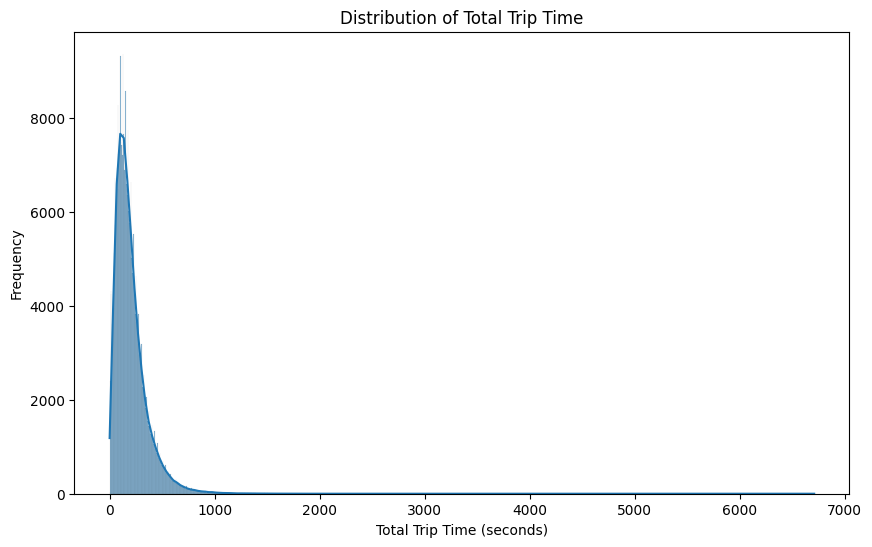

In [39]:
# Distribution of total_trip_time
plt.figure(figsize=(10, 6))
sns.histplot(trips['total_trip_time'], kde=True)
plt.title('Distribution of Total Trip Time')
plt.xlabel('Total Trip Time (seconds)')
plt.ylabel('Frequency')
plt.show()

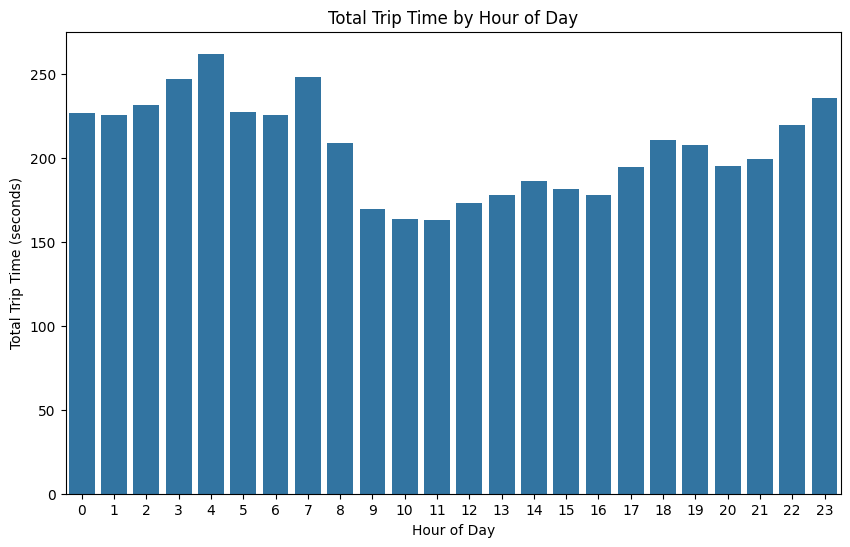

In [40]:
# total_trip_time by hour
plt.figure(figsize=(10, 6))
sns.barplot(x='hour', y='total_trip_time', data=trips, errorbar=None)
plt.title('Total Trip Time by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Total Trip Time (seconds)')
plt.show()

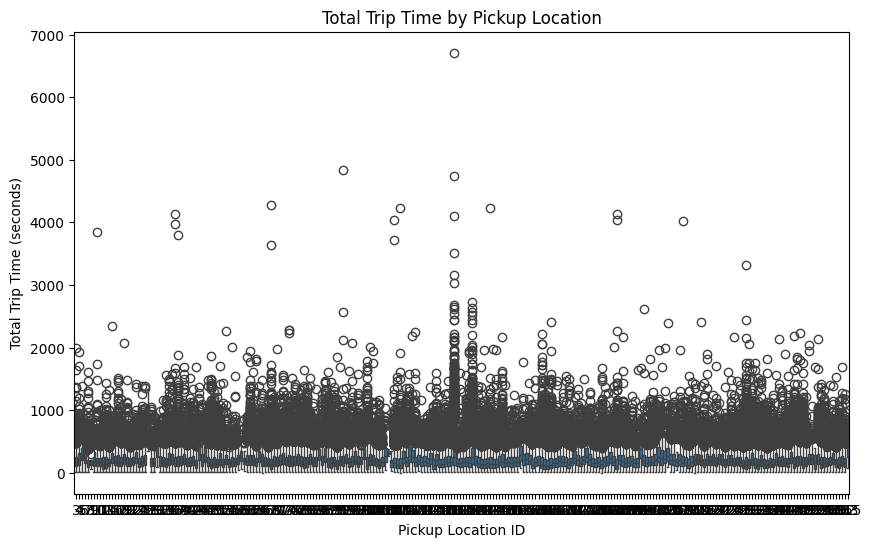

In [41]:
# total_trip_time by PULocationID
plt.figure(figsize=(10, 6))
sns.boxplot(x='PULocationID', y='total_trip_time', data=trips)
plt.title('Total Trip Time by Pickup Location')
plt.xlabel('Pickup Location ID')
plt.ylabel('Total Trip Time (seconds)')
plt.show()

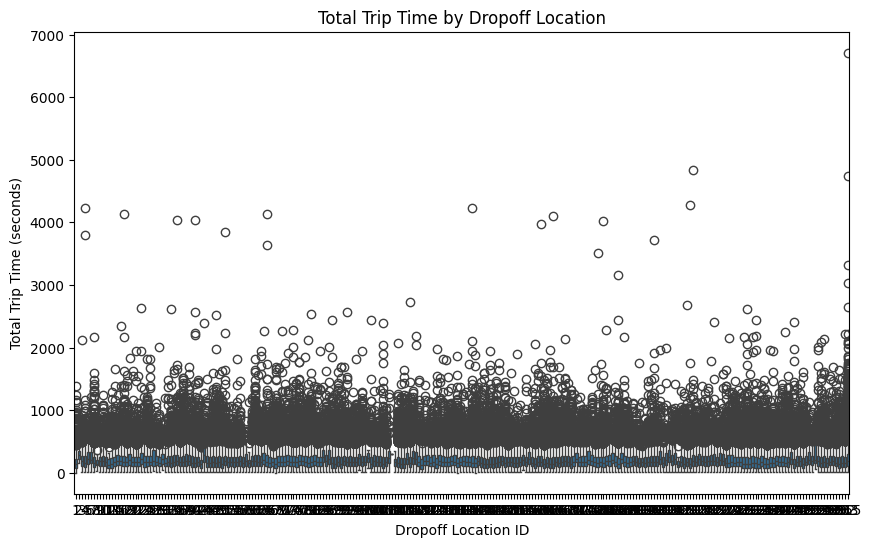

In [42]:
# total_trip_time by DOLocationID
plt.figure(figsize=(10, 6))
sns.boxplot(x='DOLocationID', y='total_trip_time', data=trips)
plt.title('Total Trip Time by Dropoff Location')
plt.xlabel('Dropoff Location ID')
plt.ylabel('Total Trip Time (seconds)')
plt.show()

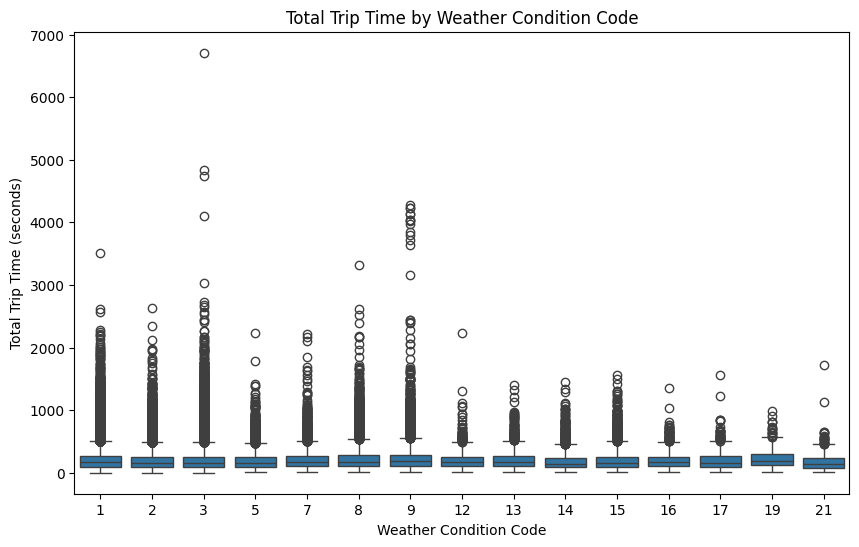

In [43]:
# Box plot of total_trip_time by weather_condition_code
plt.figure(figsize=(10, 6))
sns.boxplot(x='weather_condition_code', y='total_trip_time', data=trips)
plt.title('Total Trip Time by Weather Condition Code')
plt.xlabel('Weather Condition Code')
plt.ylabel('Total Trip Time (seconds)')
plt.show()

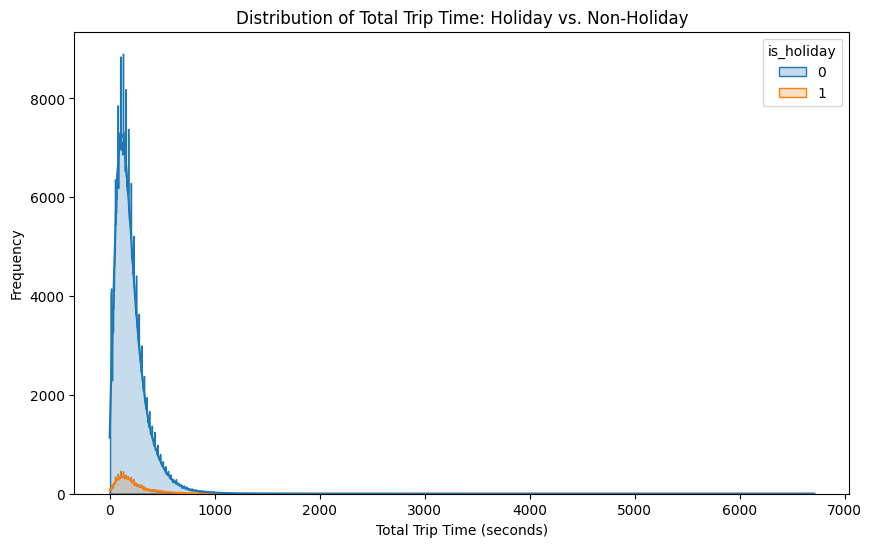

In [44]:
# Distribution of total_trip_time on holidays vs. non-holidays
plt.figure(figsize=(10, 6))
sns.histplot(data=trips, x='total_trip_time', hue='is_holiday', kde=True, element='step')
plt.title('Distribution of Total Trip Time: Holiday vs. Non-Holiday')
plt.xlabel('Total Trip Time (seconds)')
plt.ylabel('Frequency')
plt.show()

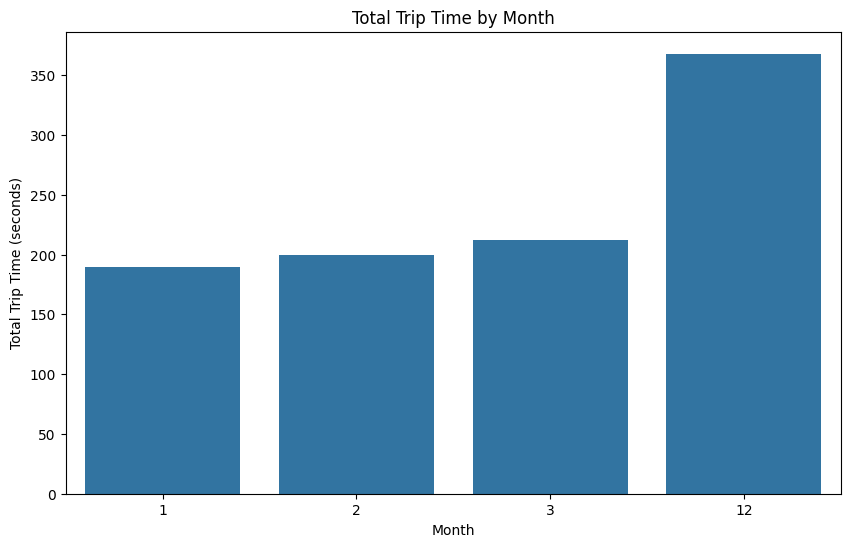

In [45]:
#analyze how the total_trip_time changes across different months, which might reveal seasonal patterns
plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='total_trip_time', data=trips, errorbar=None)
plt.title('Total Trip Time by Month')
plt.xlabel('Month')
plt.ylabel('Total Trip Time (seconds)')
plt.show()

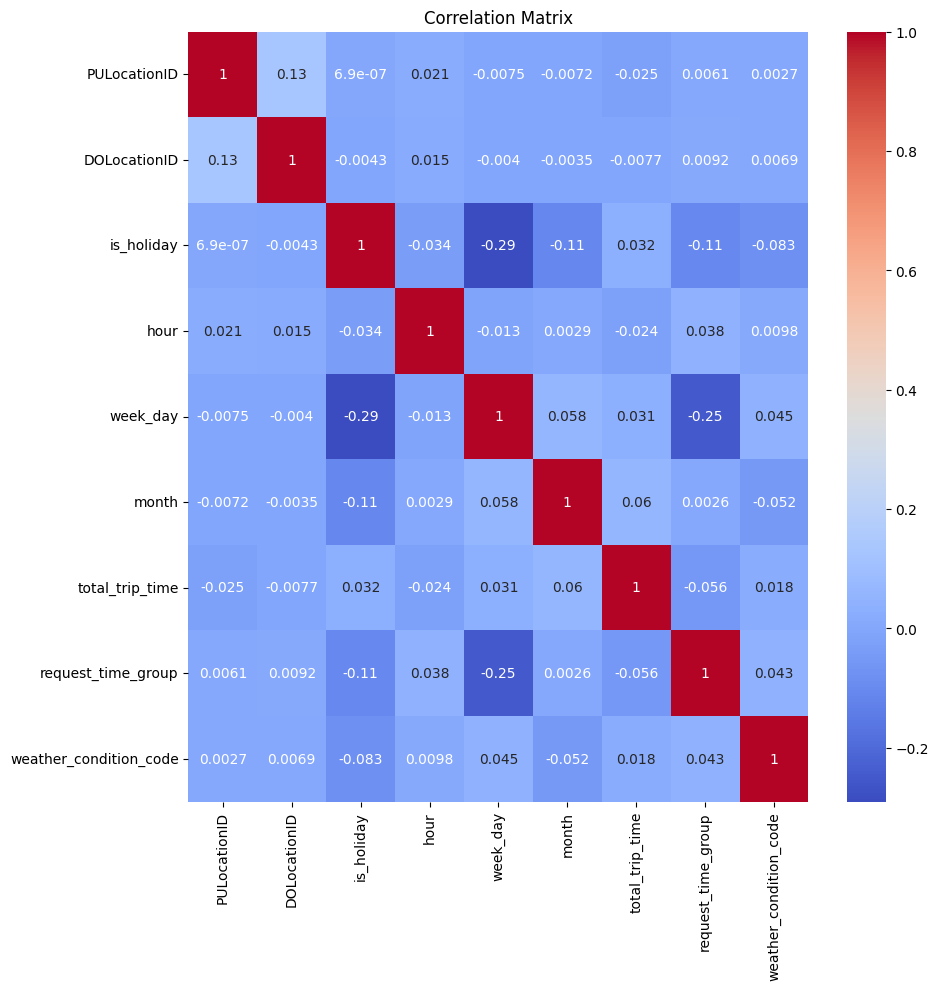

In [46]:
#correlation heatmap, to check correlation between different variables
#results range from -1 to 1 where 1 is perfect correlation and -1 is perfect negative correlation
correlation_matrix = trips.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

### 5.0 Machine Learning Models
#### 5.1 Linear Regression

In [47]:
""" 
From the correlation Matrix, there is a low correlation/weak linear relationship between total_trip_time and the other variables. 
This suggest the use of complex models to capture the non-linear relationship.

Starting with a simple linear regression model, even though the correlation is low, the model is able to give a baseline comparison.
"""

# Define features and target
X = trips.drop('total_trip_time', axis=1)
y = trips['total_trip_time']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Fit the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate the model
print('Accuracy  on test dataset: ', lr_model.score(X_test, y_test) )
print('RMSE  on test dataset: ', np.sqrt(mean_squared_error(y_test, lr_model.predict(X_test))))
print('MAE  on test dataset: ', mean_absolute_error(y_test, lr_model.predict(X_test)))


Accuracy  on test dataset:  0.01077279963764366
RMSE  on test dataset:  153.7610654684311
MAE  on test dataset:  109.65232147447608


In [48]:
#save model to pickle
# import pickle

# pickle.dump(lr_model, open('lr_model.pkl', 'wb'))


##### 5.1.1. Linear Regression with recursive feature elimination process

In [49]:
sel = RFE(LinearRegression(fit_intercept = True), n_features_to_select=5, step=1)
sel = sel.fit(X, y)
sel.support_

rfe_data = X.columns[sel.support_]

#print the selected features
rfe_data

Index(['is_holiday', 'week_day', 'month', 'request_time_group',
       'weather_condition_code'],
      dtype='object')

In [50]:
X1 = trips[rfe_data]
y1 = trips['total_trip_time']

#split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

#run linear regression model on the train set
lr_model = LinearRegression(fit_intercept = True).fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate the model
print('Accuracy  on test dataset: ', lr_model.score(X_test, y_test) )
print('RMSE  on test dataset: ', np.sqrt(mean_squared_error(y_test, lr_model.predict(X_test))))
print('MAE  on test dataset: ', mean_absolute_error(y_test, lr_model.predict(X_test)))

Accuracy  on test dataset:  0.009504210444254091
RMSE  on test dataset:  157.4748021105036
MAE  on test dataset:  110.14405685948923


In [51]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score

# Create a pipeline for scaling and polynomial features
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # Add interaction terms
    ('linear', LinearRegression())
])

# Train the model using cross-validation
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Evaluate the model
print('Accuracy  on test dataset: ', lr_model.score(X_test, y_test) )
print('RMSE  on test dataset: ', np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test))))
print('MAE  on test dataset: ', mean_absolute_error(y_test, lr_model.predict(X_test)))

Accuracy  on test dataset:  0.009504210444254091
RMSE  on test dataset:  156.15499684346352
MAE  on test dataset:  110.14405685948923


#### 5.2. Random Forest

In [52]:
# RF can capture complex non-linear relationships
# Random Forest Regression
rf_model = RandomForestRegressor(max_depth=2, random_state=0)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print('Accuracy  on test dataset: ', rf_model.score(X_test, y_test) )
print('RMSE  on test dataset: ', np.sqrt(mean_squared_error(y_test, rf_model.predict(X_test))))
print('MAE  on test dataset: ', mean_absolute_error(y_test, rf_model.predict(X_test)))

Accuracy  on test dataset:  0.016445953605378594
RMSE  on test dataset:  156.92201244820916
MAE  on test dataset:  109.74793955492838


##### 5.2.1 Optimising Random Forest

#### 5.3. LightGBM

In [53]:
# LGBM can capture complex non-linear relationships
# LightGBM Regression
lgbm_model = LGBMRegressor(random_state=0)
lgbm_model.fit(X_train, y_train)

# Make predictions
y_pred = lgbm_model.predict(X_test)

# Evaluate the model
print('Accuracy  on test dataset: ', lgbm_model.score(X_test, y_test) )
print('RMSE  on test dataset: ', np.sqrt(mean_squared_error(y_test, lgbm_model.predict(X_test))))
print('MAE  on test dataset: ', mean_absolute_error(y_test, lgbm_model.predict(X_test)))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33
[LightGBM] [Info] Number of data points in the train set: 383520, number of used features: 5
[LightGBM] [Info] Start training from score 200.753030
Accuracy  on test dataset:  0.04092867691836233
RMSE  on test dataset:  154.95664582629198
MAE  on test dataset:  108.29525773591465


In [54]:
# Hyperparameter tuning
param_grid = {
    'num_leaves': [31, 50],
    'max_depth': [-1, 10],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [50, 100]
}

lgbm_model = LGBMRegressor(random_state=42)
grid_search = GridSearchCV(lgbm_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model
best_lgbm = grid_search.best_estimator_
y_pred = best_lgbm.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
print(f'Optimized LightGBM MSE: {mse}')


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33
[LightGBM] [Info] Number of data points in the train set: 383520, number of used features: 5
[LightGBM] [Info] Start training from score 200.753030
Optimized LightGBM MSE: 24004.516873068027


In [55]:
print('Accuracy  on test dataset: ', best_lgbm.score(X_test, y_test) )
print('RMSE  on test dataset: ', np.sqrt(mean_squared_error(y_test, best_lgbm.predict(X_test))))
print('MAE  on test dataset: ', mean_absolute_error(y_test, best_lgbm.predict(X_test)))

Accuracy  on test dataset:  0.04121007724582415
RMSE  on test dataset:  154.93391130758957
MAE  on test dataset:  108.27981435486379


In [56]:
# Hyperparameter tuning with RandomizedSearchCV
param_distributions = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.2],
    'max_depth': [5, 7],
    'num_leaves': [20, 31],
    'min_child_samples': [20, 50],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8]
}

# Randomized search with early stopping
random_search = RandomizedSearchCV(
    lgbm_model,
    param_distributions=param_distributions,
    n_iter=10,  # Number of parameter settings sampled
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the model with early stopping
random_search.fit(
    X_train, y_train, 
    eval_set=[(X_test, y_test)],
    eval_metric='mse'
)

# Best model
best_lgbm = random_search.best_estimator_

# Make predictions
y_pred = best_lgbm.predict(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33
[LightGBM] [Info] Number of data points in the train set: 383520, number of used features: 5
[LightGBM] [Info] Start training from score 200.753030


In [57]:
print('Accuracy  on test dataset: ', best_lgbm.score(X_test, y_test) )
print('RMSE  on test dataset: ', np.sqrt(mean_squared_error(y_test, best_lgbm.predict(X_test))))
print('MAE  on test dataset: ', mean_absolute_error(y_test, best_lgbm.predict(X_test)))

Accuracy  on test dataset:  0.04065675088843912
RMSE  on test dataset:  154.97861174173292
MAE  on test dataset:  108.32108253969105


In [58]:
# Hyperparameter tuning with RandomizedSearchCV
param_distributions = {
    'n_estimators': [50, 100, 200],        # Range of trees in the forest
    'max_depth': [5, 10, 20, None],        # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],       # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],         # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]             # Whether bootstrap samples are used when building trees
}

# Randomized search with fewer iterations (e.g., 10 iterations)
random_search = RandomizedSearchCV(
    rf_model, 
    param_distributions=param_distributions, 
    n_iter=10,  # Number of different combinations to try
    cv=3,       # Number of cross-validation folds
    scoring='neg_mean_squared_error', 
    verbose=1,  # Prints progress messages
    n_jobs=-1,  # Use all available cores
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Best model
best_rf = random_search.best_estimator_

# Make predictions
y_pred = best_rf.predict(X_test)

print('Accuracy  on test dataset: ', best_rf.score(X_test, y_test) )
print('RMSE  on test dataset: ', np.sqrt(mean_squared_error(y_test, best_rf.predict(X_test))))
print('MAE  on test dataset: ', mean_absolute_error(y_test, best_rf.predict(X_test)))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Accuracy  on test dataset:  0.041078911147024
RMSE  on test dataset:  154.94450871858078
MAE  on test dataset:  108.29731485570946


In [59]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# # Evaluate the model
print('Accuracy  on test dataset: ', best_rf.score(X_test, y_test) )
print('RMSE  on test dataset: ', np.sqrt(mean_squared_error(y_test, best_rf.predict(X_test))))
print('MAE  on test dataset: ', mean_absolute_error(y_test, best_rf.predict(X_test)))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Accuracy  on test dataset:  0.04065875663072405
RMSE  on test dataset:  154.9784497312546
MAE  on test dataset:  108.28971234167437


In [60]:
import xgboost as xgb
# Convert data to DMatrix format (optional but recommended for efficiency)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Simplified hyperparameter grid
param_grid = {
    'max_depth': [3, 5],               # Reduced tree depth
    'learning_rate': [0.1, 0.01],      # Reasonable learning rates
    'n_estimators': [50, 100],         # Fewer trees
    'subsample': [0.7, 1],             # Subsample of training data
    'colsample_bytree': [0.7, 1],      # Subsample of features
}

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=2)  # Limit to 2 threads

# Initialize GridSearchCV with a smaller search space
grid_search = GridSearchCV(
    xgb_model, 
    param_grid, 
    cv=3,  # Reduce cross-validation folds to 3
    scoring='neg_mean_squared_error', 
    n_jobs=-1,  # Use all available cores for the grid search, but control the cores in XGBoost
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best model
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
print(f'Optimized XGBoost MSE: {mse}')

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Optimized XGBoost MSE: 24052.23485152744


In [61]:
# # Evaluate the model
print('Accuracy  on test dataset: ', best_xgb.score(X_test, y_test) )
print('RMSE  on test dataset: ', np.sqrt(mean_squared_error(y_test, best_xgb.predict(X_test))))
print('MAE  on test dataset: ', mean_absolute_error(y_test, best_xgb.predict(X_test)))

Accuracy  on test dataset:  0.03930412274888473
RMSE  on test dataset:  155.0878294758407
MAE  on test dataset:  108.37393244272677


In [63]:
from sklearn.ensemble import GradientBoostingRegressor

reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_train)

# Model Accuracy on testing dataset
print('The Accuracy  on the testing dataset is: ', reg.score(X_test, y_test) )
print('The RMSE  on the testing dataset is: ', np.sqrt(mean_squared_error(y_test,reg.predict(X_test))))
print('The MAE  on the testing dataset is: ',mean_absolute_error(y_test,reg.predict(X_test)))

The Accuracy  on the testing dataset is:  0.033778244962256565
The RMSE  on the testing dataset is:  155.53321890285116
The MAE  on the testing dataset is:  108.66121717249814


In [64]:
# optimizing XGBoost Regressor
params = { 'max_depth': [3,6,9,12],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}

xgbr = xgb.XGBRegressor(seed = 20)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

clf.fit(X_train, y_train)

print("Best parameters:", clf.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 1000}


In [65]:
clf.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 12,
 'n_estimators': 1000}

In [67]:
# Training the model on best parameters

xgbr = xgb.XGBRegressor(seed = 20, colsample_bytree = 0.7, learning_rate= 0.1, max_depth=12, n_estimators=500)
xgbr.fit(X_train, y_train)
xgbr

y_pred = xgbr.predict(X_train)
# Model Accuracy on testing dataset
print('The Accuracy  on the testing dataset is: ', xgbr.score(X_test, y_test) )
print('The RMSE  on the testing dataset is: ',np.sqrt(mean_squared_error(y_test,xgbr.predict(X_test))))
print('The MAE  on the testing dataset is: ',mean_absolute_error(y_test,xgbr.predict(X_test)))

The Accuracy  on the testing dataset is:  0.04036482824670251
The RMSE  on the testing dataset is:  155.00218949902438
The MAE  on the testing dataset is:  108.3447308684768


In [68]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
print(f'Optimized Random Forest MSE: {mse}')


Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [ ]:
# Hyperparameter tuning
param_grid = {
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 500]
}

lgbm_model = lgb.LGBMRegressor(random_state=42)
grid_search = GridSearchCV(lgbm_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model
best_lgbm = grid_search.best_estimator_
y_pred = best_lgbm.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
print(f'Optimized LightGBM MSE: {mse}')
